### Useful links
- [CampusX - Handwritten Digit Classification using ANN](https://www.youtube.com/watch?v=3xPT2Pk0Jds)
- [Shubham Singh - The EMNIST dataset letter recognition](https://www.youtube.com/watch?v=3xPT2Pk0Jds)
- [Emnist classification](https://github.com/sejalgupta01/EMNIST-Classification/blob/master/EMNIST_Classification%20(3).ipynb)
- [Deep learning-Deep understanding by shubham singh](https://www.youtube.com/playlist?list=PL2FZtB-DAFqk4iXGu1xK1_fUmTCjtfQhV)
- [Neural Network from Scratch | Mathematics & Python Code](https://www.youtube.com/watch?v=pauPCy_s0Ok)
- https://github.com/khelli07/ai-fnn/blob/main/README.md
- https://khelli07.medium.com/introduction-to-artificial-neural-network-in-deep-learning-aa7ba2280f50
- https://khelli07.medium.com/feedforward-neural-network-fnn-implementation-from-scratch-using-python-467f51ecca3d
- https://towardsdatascience.com/creating-neural-networks-from-scratch-in-python-6f02b5dd911
- https://subscription.packtpub.com/book/data/9781789346640/1/ch01lvl1sec05/feed-forward-propagation-from-scratch-in-python
- [Softmax Layer from Scratch ](https://www.youtube.com/watch?v=AbLvJVwySEo)

### Dependencies

In [5]:
# ! pip install torchvision
# ! pip install tqdm
# ! pip install matplotlib
# ! pip install scikit-learn
# ! pip install seaborn

In [6]:
# fix random seed
import numpy as np
np.random.seed(0)
np.random.RandomState(0)

# torch random seed
import torch
torch.manual_seed(0)

import torchvision.datasets as ds
import torchvision.transforms as transforms
from tqdm import tqdm

### Dataset

In [7]:
# Download the training and validation datasets

train_val_ds = ds.EMNIST(
    root="./data",
    split="letters",
    train=True,
    download=True,
    transform=transforms.ToTensor(),
)


In [8]:

test_ds = ds.EMNIST(
    root="./data",
    split="letters",
    train=False,
    transform=transforms.ToTensor(),
)


### Preprocessing

In [9]:
# get labels
labels = np.array(train_val_ds.targets)
# get unique labels
unique_labels = np.unique(labels)

# # print number of samples per class
# for label in unique_labels:
#     print(f"number of samples for class {label}: {np.sum(labels == label)}")

In [10]:
# remove 'N/A' label and decrease all labels by 1
train_val_ds.targets = train_val_ds.targets - 1
test_ds.targets = test_ds.targets - 1

train_val_ds.classes = train_val_ds.classes[1:]
test_ds.classes = test_ds.classes[1:]

#### Data Normalization

In [11]:
# next issue: do we need to normalize the data?
%matplotlib inline
import matplotlib.pyplot as plt

In [12]:
# normalize the data
train_val_ds.data = train_val_ds.data / torch.max(train_val_ds.data)
test_ds.data = test_ds.data / torch.max(test_ds.data)

### Train-validation split
The dataset contains 28x28 images of letters from the Latin alphabet. Split the train-validation dataset as 85%-15% to form your train set and validation set. 

In [13]:
# convert torch to numpy
train_val_ds.data = train_val_ds.data.numpy()
train_val_ds.targets = train_val_ds.targets.numpy()

# convert torch to numpy
test_ds.data = test_ds.data.numpy()
test_ds.targets = test_ds.targets.numpy()

In [14]:
# use sklearn to split train_validation_dataset into train and validation datasets
from sklearn.model_selection import train_test_split

val_per = 0.15 # validation percentage

# split train_validation_dataset into train and validation datasets as 85% and 15% respectively
train_ds, val_ds, train_labels, val_labels = train_test_split(
    train_val_ds.data,
    train_val_ds.targets,
    test_size=val_per,
    random_state=1,
)

### FFN implementation

##### Loss function
As you can see, our example model is currently random. To remedy this, we need a way to
calculate how wrong the neural network is at current predictions and begin adjusting weights
and biases to decrease error over time. Thus, our next step is to quantify how wrong the model is
through what’s defined as a loss function.

In [15]:
# no matter which loss function we’ll use, the overall loss is always a mean value of all sample losses
# common loss functions
class Loss:
    # Calculates the data and regularization losses
    # given model output and ground truth values
    def calculate(self, output, y):
        # Calculate sample losses
        sample_losses = self.forward(output, y)
        # Calculate mean loss
        data_loss = np.mean(sample_losses)
        # Return loss
        return data_loss

##### Activation function

In [16]:
class Activation:
    def forward(self, inputs):
        raise NotImplementedError
    def backward(self, grad_outputs):
        raise NotImplementedError
    

In [17]:
# ReLU activation
class ReLU(Activation):
    def forward(self, inputs):
        self.inputs = inputs
        return np.maximum(0, inputs)
    
    def backward(self, grad_outputs):
        # Since we need to modify original variable,
        # let’s make a copy of values first
        grad_inputs = grad_outputs.copy()

       # print(f"Relu grad_output shape: {grad_outputs.shape}")

        # Zero gradient where input values were negative
        grad_inputs[self.inputs <= 0] = 0

       # print(f"Relu grad_input shape: {grad_inputs.shape}")

        return grad_inputs

In [18]:
class Softmax(Activation):

    def forward(self, inputs):
        # get row max to subtract from each row
        # this is to prevent overflow
        # the max value in each row will be 0
        # the output will be extactly the same
        row_maxs = np.max(inputs, axis=1, keepdims=True)

        # Get unnormalized probabilities
        # exponentiate values
        exp_values = np.exp(inputs - row_maxs)

        # Get normalization bases for each sample
        norm_bases = np.sum(exp_values, axis=1, keepdims=True)

        # Normalize them for each sample
        probabilities = exp_values / norm_bases

        #print(f"softmax forward output shape: {probabilities.shape}")

        self.outputs = probabilities

        return probabilities
    

    # back propagation
    def backward(self, grad_output):
        # return input_grads
       # print(f"softmax-> grad_output shape: {grad_output.shape}")
        grad_input = self.outputs * (grad_output - np.sum(self.outputs * grad_output, axis=-1, keepdims=True))
       # print(f"softmax-> grad_input shape: {grad_input.shape}")
        return grad_input

In [19]:
class Optimizer:
    # Update parameters
    def update_weights(self, weights, grad_weights):
        raise NotImplementedError
    # update bias
    def update_bias(self, bias, grad_bias):
        raise NotImplementedError

##### layer

In [20]:
class Layer:
    def forward(self, inputs):
        raise NotImplementedError
    
    def backward(self, grad_outputs, optimizer=None):
        raise NotImplementedError
    
    def summary(self):
        raise NotImplementedError

In [21]:
class Flatten(Layer):
    def __init__(self):
        self.input_shape = None
    
    def forward(self, inputs):
        # chec if 2D for batch size
        if len(inputs.shape) <= 1:
            raise ValueError(f"Flatten layer input shape must be greater than 1D. Got {inputs.shape}.")

        # save shape for backward pass
        self.input_shape = inputs.shape

        # flatten inputs
        return inputs.reshape(inputs.shape[0], -1)
    
    def backward(self, grad_outputs, optimizer=None):
        # reshape gradient
        return grad_outputs.reshape(self.input_shape)
    
    def summary(self):
        return "Flatten"

In [22]:
# Dense or fully connected layer
class DenseLayer(Layer):
    # Here, we’re setting weights to be random and biases to be 0
    def __init__(self, 
                 n_inputs:int, 
                 n_neurons:int, 
                 activation:Activation,
                 learning_rate:float = 0.001,
                 debug:bool = False,
                 ) -> None:
        # Xavier initialization
        # We divide by n_inputs to reduce the variance of our outputs
        # and make sure that they are all in the same range
        self.weights = np.random.randn(n_inputs, n_neurons) / np.sqrt(n_inputs)

        # print max and min weights
        if debug:
            print(f"weights shape: {self.weights.shape}")
            print(f"weight (min, max) = ({np.min(self.weights)}, {np.max(self.weights)})")
           
        # xaiver initialization
        self.biases = np.zeros((1, n_neurons))

        if debug:
            print(f"baises shape: {self.biases.shape}")
            print(f"bias (min, max) = ({np.min(self.biases)}, {np.max(self.biases)})")
            

        # activation function
        self.activation = activation
        # learning rate
        self.learning_rate = learning_rate

    # Forward pass
    # When we pass data through a model from beginning to end, this is called a forward pass. 
    def forward(self, inputs:np.ndarray):
        # check input shape
        if len(inputs.shape) != 2:
            raise ValueError(f"input shape must be 2D, got {len(inputs.shape)}D")
        
        # save input
        self.inputs = inputs

        # inputs shape: (batch_size, n_inputs)
        # weights shape: (n_inputs, n_neurons)
        # biases shape: (1, n_neurons)
        # output shape: (batch_size, n_neurons) i.e for each sample, we get n_neurons outputs
        out =  np.dot(inputs, self.weights) + self.biases
     
        out = self.activation.forward(out)
        return out
    
    def backward(self, grad_output:np.ndarray, optimizer:Optimizer):
        # activation function derivative
        grad_output = self.activation.backward(grad_output)

      #  print(f"denselayer-> grad_output shape: {grad_output.shape}")

        # Gradients on parameters
        # dE/dW = dE/dY * dY/dW = dE/dY * X.T
        grad_weights = np.dot(self.inputs.T, grad_output)

        # dE/dB = dE/dY * dY/dB = dE/dY * 1
        grad_biases = grad_output.mean(axis=0) * self.inputs.shape[0]

        # Gradient on values
        # dE/dX = dE/dY * dY/dX = W.T * dE/dY
        grad_inputs = np.dot(grad_output, self.weights.T)

    
        self.weights = optimizer.update_weights(self.weights, grad_weights)
        self.biases = optimizer.update_bias(self.biases,grad_biases)

        return grad_inputs
    
    def summary(self):
        activation_name = self.activation.__class__.__name__
        return f"Dense({self.weights.shape[0]}, {self.weights.shape[1]}), activation: {activation_name}"
    

#### Dropout layer

In [23]:
# Dropout
class DropoutLayer:
    # Init
    def __init__(self, dropout_rate=0.3):
        # Store rate, we invert it as for example for dropout
        # of 0.1 we need success rate of 0.9
        self.rate = 1 - dropout_rate

    # Forward pass
    def forward(self, inputs):
        # Generate and save scaled mask
        self.mask = np.random.binomial(1, self.rate, size=inputs.shape) / self.rate

        # Apply mask to output values
        return inputs * self.mask

    # Backward pass
    def backward(self, grad_output, _):
        # Gradient on values
        return grad_output * self.mask
    
    def summary(self):
        return f"Dropout(rate: {1-self.rate})"

#### Categorical cross entropy derivative

In [24]:
class CategoricalCrossEntropyLoss(Loss):
    # Forward pass
    def forward(self, y_pred, y_true):
        # Number of samples in a batch
        samples = len(y_pred)

        # Clip data to prevent division by 0
        # Clip both sides to not drag mean towards any value
        y_pred_clipped = np.clip(y_pred, 1e-7, 1 - 1e-7)

        # Probabilities for target values-only if categorical labels
        if len(y_true.shape) == 1:
            correct_confidences = y_pred_clipped[range(samples), y_true]
        # Mask values - only for one-hot encoded labels
        elif len(y_true.shape) == 2:
            correct_confidences = np.sum(y_pred_clipped * y_true, axis=1)
        
        # Losses
        negative_log_likelihoods = -np.log(correct_confidences)
        
        return negative_log_likelihoods
    
    def backward(self, y_pred, y_true):
        # Number of samples
        samples = len(y_pred)

        # Number of labels in every sample
        # We’ll use the first sample to count them
        labels = len(y_pred[0])

        # If labels are sparse, turn them into one-hot vector
        if len(y_true.shape) == 1:
            y_true = np.eye(labels)[y_true]

        epsilon = 1e-7

        # Calculate gradient
        grad_output = -y_true / (y_pred+epsilon)
        # Normalize gradient
        grad_output = grad_output / samples

        return grad_output

#### Optimizer

In [25]:
# SGD
class SGD(Optimizer):
    # Initialize optimizer - set settings,
    # learning rate of 1. is default for this optimizer
    def __init__(self, learning_rate:float = 1.0) -> None:
        self.learning_rate = learning_rate

    # Update parameters
    def update_weights(self, weights, grad_weights):
        return weights - grad_weights * self.learning_rate
    
    # update bias
    def update_bias(self, bias, grad_bias):
        return bias - grad_bias * self.learning_rate

#### Model

In [26]:
class History:
    def __init__(self) -> None:
        self.loss = []
        self.accuracy = []
        self.val_loss = []
        self.val_accuracy = []
        self.val_f1 = []
    
    def append(self, loss, accuracy, val_loss, val_accuracy, val_f1):
        self.loss.append(loss)
        self.accuracy.append(accuracy)
        self.val_loss.append(val_loss)
        self.val_accuracy.append(val_accuracy)
        self.val_f1.append(val_f1)

In [27]:
class BestModel:
    def __init__(self) -> None:
        self.layers = None
        self.loss = np.inf
        self.accuracy = 0
        self.f1 = 0 

    def update(self, layers, loss, accuracy, f1):
        if f1 > self.f1:
            self.layers = layers.copy()
            self.loss = loss
            self.accuracy = accuracy
            self.f1 = f1

    def _forward(self, inputs):
        for layer in self.layers:
            inputs = layer.forward(inputs)
        return inputs

In [28]:
# import pickle
import pickle
# import sklern for f1 score
from sklearn.metrics import f1_score
# import confusion matrix
from sklearn.metrics import confusion_matrix
# import accuracy score
from sklearn.metrics import accuracy_score

# import seaborn and matplotlib
import seaborn as sns
import matplotlib.pyplot as plt

class FNN:
    def __init__(self, 
                 loss:Loss, 
                 optimizer:Optimizer, 
                 learning_rate:float = 0.005,
                 layers:list = [],
                 debug:bool = False,
                 ) -> None:
        self.loss = loss
        self.optimizer = optimizer
        self.learning_rate = learning_rate
        self.debug = debug

        # history
        self.history = History()
        # best model
        self.best_model = BestModel()
        # layers
        self.layers = layers

    def add(self, layer:Layer):
        self.layers.append(layer)

    # add multiple layers
    def add_all(self, layers:list):
        self.layers.extend(layers)

    # summary
    def summary(self):
        print(f"Model summary")
        print(f"==============")
        optimizer = self.optimizer.__class__.__name__
        print(f"Optimizer: {optimizer}")
        loss = self.loss.__class__.__name__
        print(f"Loss: {loss}")
        learning_rate = self.learning_rate
        print(f"Learning rate: {learning_rate}")
        for i, layer in enumerate(self.layers):
            print(f"Layer {i+1}: {layer.summary()}")
        print(f"Output shape: {self.layers[-1].weights.shape[1]}")

    def save(self, path):
        # clear unnecessary data
        for layer in self.layers:
            if hasattr(layer, "inputs"):
                layer.inputs = None
            # mask for dropout
            if hasattr(layer, "mask"):
                layer.mask = None

            # clear layers activations
            if hasattr(layer, "activation"):
                # clear inputs
                if hasattr(layer.activation, "inputs"):
                    layer.activation.inputs = None
                # clear outputs
                if hasattr(layer.activation, "outputs"):
                    layer.activation.outputs = None
                  

        self.best_model = None
        self.history = None

        # save model
        with open(path, "wb") as f:
            pickle.dump(self, f)

    def save_best_model(self, path):
        # clear unnecessary data
        for layer in self.best_model.layers:
            if hasattr(layer, "inputs"):
                layer.inputs = None
            # mask for dropout
            if hasattr(layer, "mask"):
                layer.mask = None

            # clear layers activations
            if hasattr(layer, "activation"):
                # clear inputs
                if hasattr(layer.activation, "inputs"):
                    layer.activation.inputs = None
                # clear outputs
                if hasattr(layer.activation, "outputs"):
                    layer.activation.outputs = None
                  

        # save best model
        with open(path, "wb") as f:
            pickle.dump(self.best_model, f)

    # load best model
    def load_best_model(self, path):
        # load model
        with open(path, "rb") as f:
            self.best_model = pickle.load(f)

    @staticmethod
    def load(path):
        # load model
        with open(path, "rb") as f:
            return pickle.load(f)

    def _forward(self, X):
        # Forward propagation
        for layer in self.layers:
            X = layer.forward(X)
        return X
    
    def _backward(self, grad_output):
        # Back propagation
        for layer in reversed(self.layers):
            grad_output = layer.backward(grad_output, self.optimizer)
        return grad_output

    def _calculate_accuracy(self, y_pred, y_true):
        # Calculate an accuracy
        y_pred_labels = np.argmax(y_pred, axis=1)
        return accuracy_score(y_true, y_pred_labels)
    

    def evaluate(self, X_val, y_val):
        # Calculate an accuracy
        y_pred = self._forward(X_val)
        loss = self.loss.calculate(y_pred, y_val)
        accuracy = self._calculate_accuracy(y_pred, y_val)
        f1 = f1_score(y_val, np.argmax(y_pred, axis=1), average="macro")
        return loss, accuracy, f1
    
    def predict(self, X):
        # Calculate an accuracy
        y_pred = self._forward(X)
        return y_pred

    def best_model_predict(self, X):
        # Calculate an accuracy
        y_pred = self.best_model._forward(X)
        return y_pred
    
    def best_model_evaluate(self, X_val, y_val):
        # Calculate an accuracy
        y_pred = self.best_model._forward(X_val)
        loss = self.loss.calculate(y_pred, y_val)
        accuracy = self._calculate_accuracy(y_pred, y_val)
        f1 = f1_score(y_val, np.argmax(y_pred, axis=1), average="macro")
        return loss, accuracy, f1
    
    
    def shuffle(self, X, y):
        # X and y has different shape
        # so we need to shuffle them together
        # create random index
        random_index = np.random.permutation(len(X))
        # shuffle X and y
        return X[random_index], y[random_index]
    
    
    def fit(self, X, y, X_val, y_val, epochs:int = 5, batch_size:int = 32, best_name="best_model.pkl"):
        # initialize history
        self.history = History()
        # initialize best model
        self.best_model = BestModel()

        # iterate over epochs
        # use tqdm to show progress bar
      
        for epoch in range(epochs):
            # shuffle X and y
            X, y = self.shuffle(X, y)

            epoch_loss = 0
            epoch_accuracy = 0

            # calculate number of batches
            batches = len(X) // batch_size
            if len(X) % batch_size != 0:
                batches += 1

            with tqdm(total=batches, desc="Training", bar_format="{l_bar}{bar} [ time left: {remaining} ]") as pbar:
                # iterate over batches
                for batch in range(batches):
                    # get batch start and end index
                    X_batch = X[batch*batch_size:(batch+1)*batch_size]
                    y_batch = y[batch*batch_size:(batch+1)*batch_size]

                    # forward propagation
                    y_pred = self._forward(X_batch)
                    # calculate loss
                    epoch_loss += self.loss.calculate(y_pred, y_batch)
                    # calculate accuracy
                    epoch_accuracy += self._calculate_accuracy(y_pred, y_batch)

                    # backward propagation
                    grad_output = self.loss.backward(y_pred, y_batch)
                    self._backward(grad_output)

                    pbar.update(1)

    
            loss  = epoch_loss / batches    
            accuracy = epoch_accuracy / batches

            # evaluate model on validation data
            val_loss, val_accuracy, val_f1 = self.evaluate(X_val, y_val)
            # update history
            self.history.append(loss, accuracy, val_loss, val_accuracy, val_f1)
            # update best model
            self.best_model.update(self.layers, val_loss, val_accuracy, val_f1)

            # update progress bar
            epoch_msg = f"epoch: {epoch+1}/{epochs}, loss: {loss:.4f}, accuracy: {accuracy:.4f}, val_loss: {val_loss:.4f}, val_accuracy: {val_accuracy:.4f}, val_f1: {val_f1:.4f}"
           
            print(epoch_msg)
        
        # save best model
        self.save_best_model(best_name)
                

    def plot(self):
        # plot loss
        plt.plot(self.history.loss, label="loss")
        plt.plot(self.history.val_loss, label="val_loss")
        plt.legend()
        plt.show()

        # plot accuracy
        plt.plot(self.history.accuracy, label="accuracy")
        plt.plot(self.history.val_accuracy, label="val_accuracy")
        plt.legend()
        plt.show()

        # plot f1
        plt.plot(self.history.val_f1, label="val_f1")
        plt.legend()
        plt.show()

    def plot_confusion_matrix(self, X, y):
        # get predictions
        if self.best_model.layers is not None:
            y_pred = self.best_model_predict(X)
        else:
            y_pred = self.predict(X)
        # get labels
        y_pred_labels = np.argmax(y_pred, axis=1)

        # get confusion matrix
        cm = confusion_matrix(y, y_pred_labels)

        # plot confusion matrix
        plt.figure(figsize=(10, 10))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.show()


### Training

##### Building the model

In [29]:
print(train_ds.shape)
input_shape = train_ds.shape[1:]
input_size = np.prod(input_shape)
print(f"input shape: {input_shape}")
print(f"input size: {input_size}")

(106080, 28, 28)
input shape: (28, 28)
input size: 784


In [30]:
output_size = len(np.unique(train_labels))
print(f"output size: {output_size}")

output size: 26


### Testing

learning rate: 0.005


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 1/45, loss: 2.6451, accuracy: 0.2714, val_loss: 2.0163, val_accuracy: 0.4264, val_f1: 0.4114


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 2/45, loss: 1.7380, accuracy: 0.4921, val_loss: 1.5701, val_accuracy: 0.5350, val_f1: 0.5270


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 3/45, loss: 1.4576, accuracy: 0.5680, val_loss: 1.3848, val_accuracy: 0.5897, val_f1: 0.5867


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 4/45, loss: 1.3100, accuracy: 0.6115, val_loss: 1.2568, val_accuracy: 0.6287, val_f1: 0.6260


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 5/45, loss: 1.2008, accuracy: 0.6432, val_loss: 1.1736, val_accuracy: 0.6514, val_f1: 0.6490


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 6/45, loss: 1.1137, accuracy: 0.6690, val_loss: 1.0986, val_accuracy: 0.6761, val_f1: 0.6726


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 7/45, loss: 1.0454, accuracy: 0.6879, val_loss: 1.0369, val_accuracy: 0.6949, val_f1: 0.6935


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 8/45, loss: 0.9859, accuracy: 0.7063, val_loss: 0.9816, val_accuracy: 0.7065, val_f1: 0.7053


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 9/45, loss: 0.9355, accuracy: 0.7210, val_loss: 0.9381, val_accuracy: 0.7216, val_f1: 0.7197


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 10/45, loss: 0.8897, accuracy: 0.7341, val_loss: 0.8894, val_accuracy: 0.7343, val_f1: 0.7329


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 11/45, loss: 0.8534, accuracy: 0.7449, val_loss: 0.8556, val_accuracy: 0.7418, val_f1: 0.7404


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 12/45, loss: 0.8188, accuracy: 0.7553, val_loss: 0.8276, val_accuracy: 0.7550, val_f1: 0.7542


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 13/45, loss: 0.7874, accuracy: 0.7642, val_loss: 0.8034, val_accuracy: 0.7585, val_f1: 0.7575


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 14/45, loss: 0.7590, accuracy: 0.7723, val_loss: 0.7779, val_accuracy: 0.7697, val_f1: 0.7688


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 15/45, loss: 0.7359, accuracy: 0.7783, val_loss: 0.7602, val_accuracy: 0.7724, val_f1: 0.7715


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 16/45, loss: 0.7154, accuracy: 0.7855, val_loss: 0.7363, val_accuracy: 0.7827, val_f1: 0.7817


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 17/45, loss: 0.6939, accuracy: 0.7911, val_loss: 0.7196, val_accuracy: 0.7837, val_f1: 0.7828


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 18/45, loss: 0.6764, accuracy: 0.7963, val_loss: 0.7009, val_accuracy: 0.7882, val_f1: 0.7875


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 19/45, loss: 0.6618, accuracy: 0.8010, val_loss: 0.6897, val_accuracy: 0.7919, val_f1: 0.7914


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 20/45, loss: 0.6458, accuracy: 0.8045, val_loss: 0.6718, val_accuracy: 0.7972, val_f1: 0.7968


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 21/45, loss: 0.6315, accuracy: 0.8099, val_loss: 0.6603, val_accuracy: 0.8009, val_f1: 0.8000


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 22/45, loss: 0.6182, accuracy: 0.8132, val_loss: 0.6514, val_accuracy: 0.8034, val_f1: 0.8030


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 23/45, loss: 0.6059, accuracy: 0.8175, val_loss: 0.6354, val_accuracy: 0.8081, val_f1: 0.8075


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 24/45, loss: 0.5951, accuracy: 0.8198, val_loss: 0.6271, val_accuracy: 0.8105, val_f1: 0.8101


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 25/45, loss: 0.5839, accuracy: 0.8219, val_loss: 0.6228, val_accuracy: 0.8113, val_f1: 0.8108


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 26/45, loss: 0.5755, accuracy: 0.8241, val_loss: 0.6072, val_accuracy: 0.8155, val_f1: 0.8150


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 27/45, loss: 0.5663, accuracy: 0.8272, val_loss: 0.6011, val_accuracy: 0.8162, val_f1: 0.8158


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 28/45, loss: 0.5538, accuracy: 0.8303, val_loss: 0.5841, val_accuracy: 0.8244, val_f1: 0.8241


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 29/45, loss: 0.5450, accuracy: 0.8341, val_loss: 0.5768, val_accuracy: 0.8251, val_f1: 0.8247


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 30/45, loss: 0.5427, accuracy: 0.8351, val_loss: 0.5743, val_accuracy: 0.8263, val_f1: 0.8259


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 31/45, loss: 0.5306, accuracy: 0.8390, val_loss: 0.5707, val_accuracy: 0.8280, val_f1: 0.8277


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 32/45, loss: 0.5260, accuracy: 0.8387, val_loss: 0.5596, val_accuracy: 0.8306, val_f1: 0.8303


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 33/45, loss: 0.5168, accuracy: 0.8416, val_loss: 0.5564, val_accuracy: 0.8332, val_f1: 0.8328


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 34/45, loss: 0.5102, accuracy: 0.8440, val_loss: 0.5484, val_accuracy: 0.8325, val_f1: 0.8322


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 35/45, loss: 0.5016, accuracy: 0.8458, val_loss: 0.5403, val_accuracy: 0.8367, val_f1: 0.8364


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 36/45, loss: 0.4995, accuracy: 0.8466, val_loss: 0.5385, val_accuracy: 0.8388, val_f1: 0.8384


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 37/45, loss: 0.4925, accuracy: 0.8482, val_loss: 0.5300, val_accuracy: 0.8363, val_f1: 0.8361


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 38/45, loss: 0.4872, accuracy: 0.8504, val_loss: 0.5289, val_accuracy: 0.8396, val_f1: 0.8394


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 39/45, loss: 0.4806, accuracy: 0.8520, val_loss: 0.5264, val_accuracy: 0.8392, val_f1: 0.8389


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 40/45, loss: 0.4781, accuracy: 0.8511, val_loss: 0.5172, val_accuracy: 0.8393, val_f1: 0.8389


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 41/45, loss: 0.4693, accuracy: 0.8556, val_loss: 0.5192, val_accuracy: 0.8389, val_f1: 0.8384


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 42/45, loss: 0.4640, accuracy: 0.8562, val_loss: 0.5149, val_accuracy: 0.8468, val_f1: 0.8464


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 43/45, loss: 0.4610, accuracy: 0.8573, val_loss: 0.5028, val_accuracy: 0.8476, val_f1: 0.8475


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 44/45, loss: 0.4564, accuracy: 0.8581, val_loss: 0.5031, val_accuracy: 0.8436, val_f1: 0.8435


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 45/45, loss: 0.4535, accuracy: 0.8578, val_loss: 0.4954, val_accuracy: 0.8459, val_f1: 0.8456


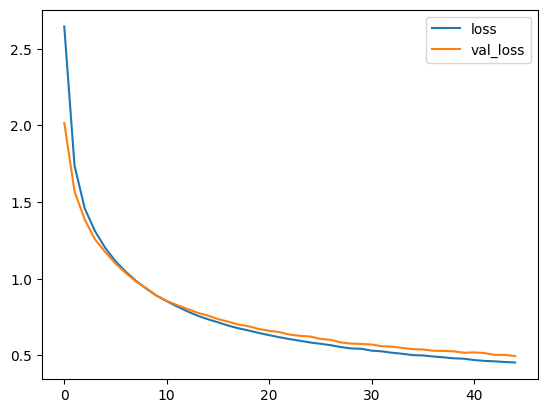

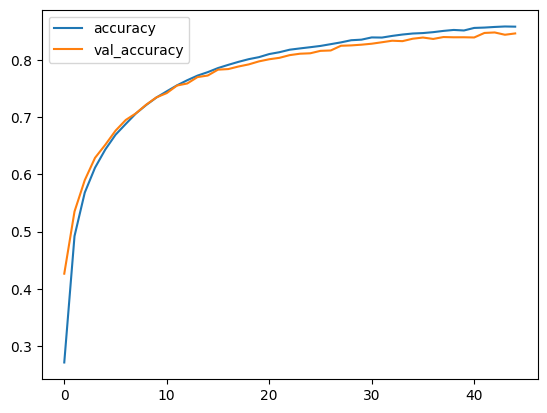

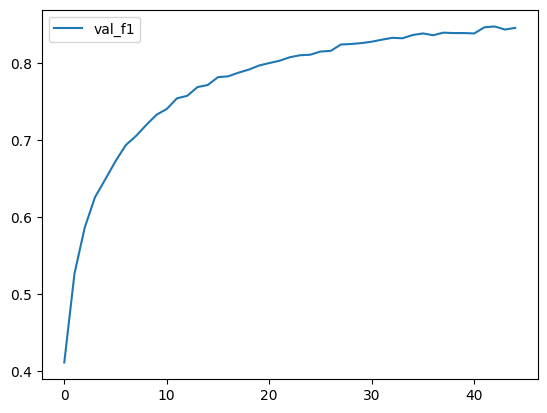

test loss: 0.49314939191332635, test accuracy: 0.8478365384615385, f1: 0.8474889366775048
best test loss: 0.49557195359335887, test accuracy: 0.8477884615384615, test f1: 0.8474192103968627


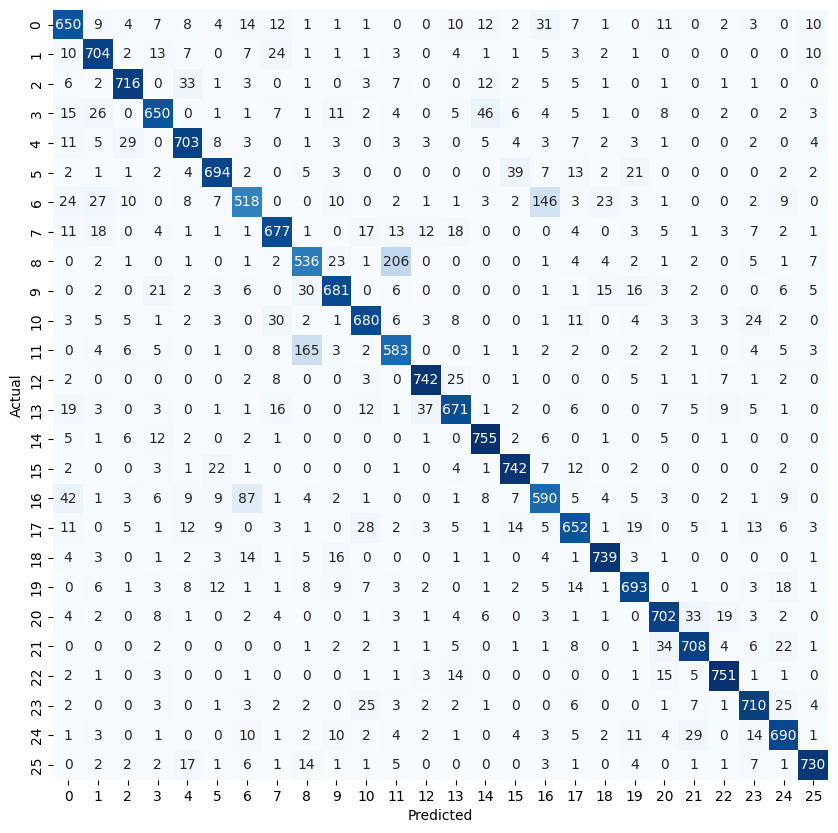

learning rate: 0.0025


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 1/45, loss: 3.0162, accuracy: 0.1787, val_loss: 2.6732, val_accuracy: 0.3006, val_f1: 0.2702


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 2/45, loss: 2.3119, accuracy: 0.3687, val_loss: 2.0283, val_accuracy: 0.4314, val_f1: 0.4159


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 3/45, loss: 1.8551, accuracy: 0.4652, val_loss: 1.7330, val_accuracy: 0.4987, val_f1: 0.4902


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 4/45, loss: 1.6399, accuracy: 0.5151, val_loss: 1.5752, val_accuracy: 0.5363, val_f1: 0.5290


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 5/45, loss: 1.5112, accuracy: 0.5527, val_loss: 1.4705, val_accuracy: 0.5681, val_f1: 0.5630


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 6/45, loss: 1.4157, accuracy: 0.5802, val_loss: 1.3803, val_accuracy: 0.5911, val_f1: 0.5870


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 7/45, loss: 1.3423, accuracy: 0.6007, val_loss: 1.3227, val_accuracy: 0.6068, val_f1: 0.6024


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 8/45, loss: 1.2806, accuracy: 0.6190, val_loss: 1.2648, val_accuracy: 0.6274, val_f1: 0.6230


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 9/45, loss: 1.2285, accuracy: 0.6342, val_loss: 1.2207, val_accuracy: 0.6374, val_f1: 0.6339


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 10/45, loss: 1.1784, accuracy: 0.6499, val_loss: 1.1725, val_accuracy: 0.6550, val_f1: 0.6523


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 11/45, loss: 1.1376, accuracy: 0.6618, val_loss: 1.1326, val_accuracy: 0.6642, val_f1: 0.6621


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 12/45, loss: 1.0998, accuracy: 0.6722, val_loss: 1.0962, val_accuracy: 0.6743, val_f1: 0.6715


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 13/45, loss: 1.0634, accuracy: 0.6825, val_loss: 1.0685, val_accuracy: 0.6822, val_f1: 0.6800


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 14/45, loss: 1.0309, accuracy: 0.6929, val_loss: 1.0325, val_accuracy: 0.6926, val_f1: 0.6908


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 15/45, loss: 0.9999, accuracy: 0.7023, val_loss: 1.0048, val_accuracy: 0.7043, val_f1: 0.7026


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 16/45, loss: 0.9722, accuracy: 0.7096, val_loss: 0.9796, val_accuracy: 0.7108, val_f1: 0.7088


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 17/45, loss: 0.9486, accuracy: 0.7168, val_loss: 0.9607, val_accuracy: 0.7143, val_f1: 0.7128


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 18/45, loss: 0.9262, accuracy: 0.7228, val_loss: 0.9328, val_accuracy: 0.7241, val_f1: 0.7230


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 19/45, loss: 0.9010, accuracy: 0.7314, val_loss: 0.9106, val_accuracy: 0.7276, val_f1: 0.7260


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 20/45, loss: 0.8830, accuracy: 0.7363, val_loss: 0.9004, val_accuracy: 0.7333, val_f1: 0.7323


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 21/45, loss: 0.8604, accuracy: 0.7435, val_loss: 0.8715, val_accuracy: 0.7401, val_f1: 0.7390


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 22/45, loss: 0.8417, accuracy: 0.7487, val_loss: 0.8549, val_accuracy: 0.7435, val_f1: 0.7425


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 23/45, loss: 0.8261, accuracy: 0.7543, val_loss: 0.8421, val_accuracy: 0.7459, val_f1: 0.7443


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 24/45, loss: 0.8097, accuracy: 0.7575, val_loss: 0.8241, val_accuracy: 0.7576, val_f1: 0.7570


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 25/45, loss: 0.7960, accuracy: 0.7609, val_loss: 0.8113, val_accuracy: 0.7598, val_f1: 0.7586


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 26/45, loss: 0.7811, accuracy: 0.7643, val_loss: 0.8039, val_accuracy: 0.7601, val_f1: 0.7591


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 27/45, loss: 0.7689, accuracy: 0.7698, val_loss: 0.7828, val_accuracy: 0.7668, val_f1: 0.7662


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 28/45, loss: 0.7556, accuracy: 0.7735, val_loss: 0.7666, val_accuracy: 0.7725, val_f1: 0.7717


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 29/45, loss: 0.7387, accuracy: 0.7780, val_loss: 0.7605, val_accuracy: 0.7721, val_f1: 0.7712


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 30/45, loss: 0.7288, accuracy: 0.7810, val_loss: 0.7514, val_accuracy: 0.7780, val_f1: 0.7772


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 31/45, loss: 0.7225, accuracy: 0.7835, val_loss: 0.7422, val_accuracy: 0.7797, val_f1: 0.7789


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 32/45, loss: 0.7072, accuracy: 0.7868, val_loss: 0.7338, val_accuracy: 0.7812, val_f1: 0.7803


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 33/45, loss: 0.6979, accuracy: 0.7897, val_loss: 0.7197, val_accuracy: 0.7841, val_f1: 0.7833


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 34/45, loss: 0.6891, accuracy: 0.7930, val_loss: 0.7110, val_accuracy: 0.7870, val_f1: 0.7861


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 35/45, loss: 0.6800, accuracy: 0.7962, val_loss: 0.7003, val_accuracy: 0.7920, val_f1: 0.7917


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 36/45, loss: 0.6736, accuracy: 0.7972, val_loss: 0.6913, val_accuracy: 0.7912, val_f1: 0.7907


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 37/45, loss: 0.6640, accuracy: 0.8005, val_loss: 0.6911, val_accuracy: 0.7907, val_f1: 0.7901


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 38/45, loss: 0.6569, accuracy: 0.8031, val_loss: 0.6800, val_accuracy: 0.7952, val_f1: 0.7947


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 39/45, loss: 0.6471, accuracy: 0.8049, val_loss: 0.6743, val_accuracy: 0.7971, val_f1: 0.7967


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 40/45, loss: 0.6391, accuracy: 0.8069, val_loss: 0.6625, val_accuracy: 0.8001, val_f1: 0.7996


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 41/45, loss: 0.6319, accuracy: 0.8090, val_loss: 0.6632, val_accuracy: 0.7975, val_f1: 0.7971


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 42/45, loss: 0.6264, accuracy: 0.8091, val_loss: 0.6547, val_accuracy: 0.8025, val_f1: 0.8016


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 43/45, loss: 0.6178, accuracy: 0.8126, val_loss: 0.6537, val_accuracy: 0.8034, val_f1: 0.8027


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 44/45, loss: 0.6125, accuracy: 0.8135, val_loss: 0.6392, val_accuracy: 0.8070, val_f1: 0.8065


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 45/45, loss: 0.6053, accuracy: 0.8162, val_loss: 0.6361, val_accuracy: 0.8118, val_f1: 0.8112


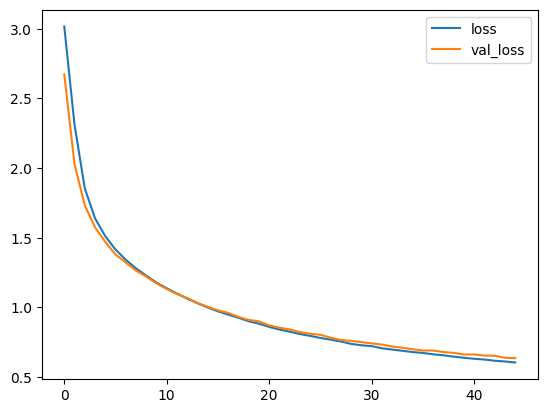

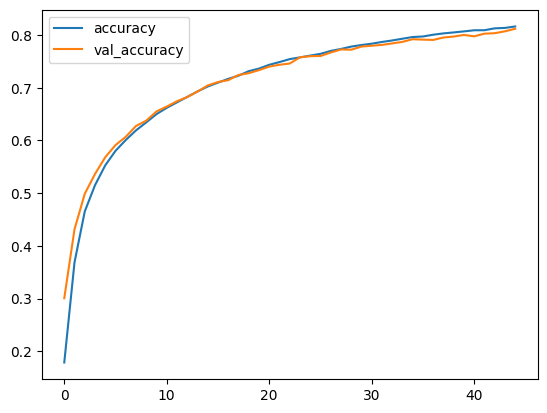

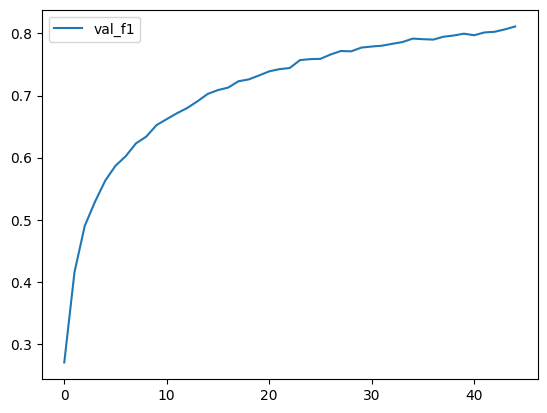

test loss: 0.6343862409001099, test accuracy: 0.8108173076923076, f1: 0.8102848942937428
best test loss: 0.6278607315686643, test accuracy: 0.8129326923076923, test f1: 0.8122620287561383


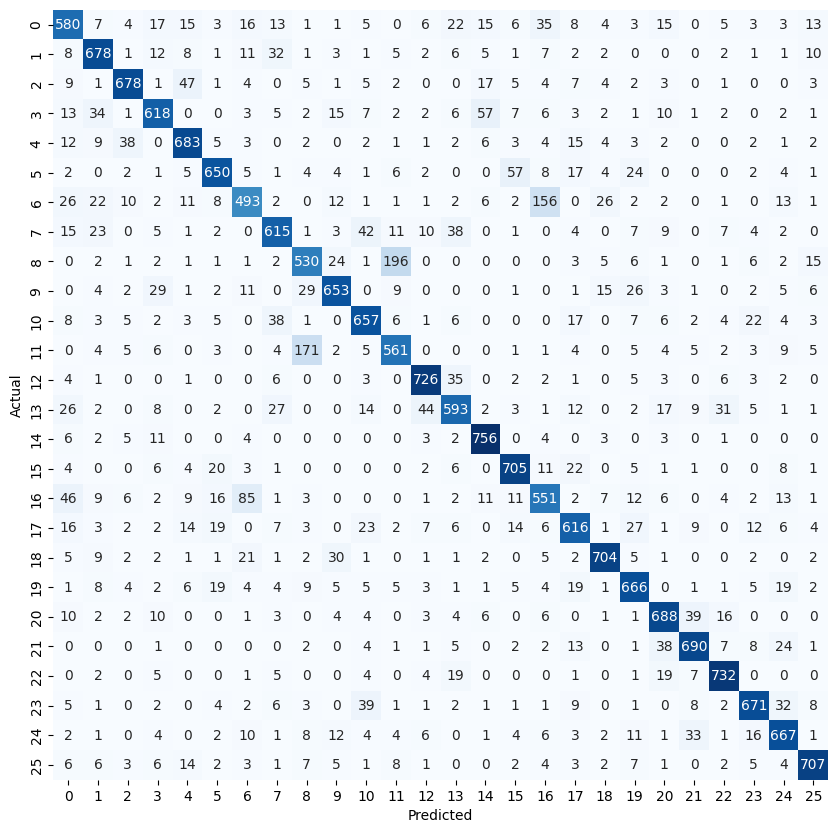

learning rate: 0.001


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 1/45, loss: 3.2119, accuracy: 0.0792, val_loss: 3.1206, val_accuracy: 0.1361, val_f1: 0.1260


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 2/45, loss: 3.0044, accuracy: 0.1989, val_loss: 2.8710, val_accuracy: 0.2483, val_f1: 0.2256


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 3/45, loss: 2.7057, accuracy: 0.2945, val_loss: 2.5488, val_accuracy: 0.3287, val_f1: 0.3056


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 4/45, loss: 2.3947, accuracy: 0.3554, val_loss: 2.2601, val_accuracy: 0.3813, val_f1: 0.3633


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 5/45, loss: 2.1372, accuracy: 0.4051, val_loss: 2.0481, val_accuracy: 0.4243, val_f1: 0.4116


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 6/45, loss: 1.9551, accuracy: 0.4431, val_loss: 1.8870, val_accuracy: 0.4606, val_f1: 0.4504


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 7/45, loss: 1.8285, accuracy: 0.4694, val_loss: 1.7914, val_accuracy: 0.4798, val_f1: 0.4704


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 8/45, loss: 1.7347, accuracy: 0.4919, val_loss: 1.7010, val_accuracy: 0.5024, val_f1: 0.4944


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 9/45, loss: 1.6595, accuracy: 0.5131, val_loss: 1.6412, val_accuracy: 0.5161, val_f1: 0.5091


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 10/45, loss: 1.5959, accuracy: 0.5290, val_loss: 1.5842, val_accuracy: 0.5332, val_f1: 0.5266


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 11/45, loss: 1.5470, accuracy: 0.5430, val_loss: 1.5377, val_accuracy: 0.5482, val_f1: 0.5415


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 12/45, loss: 1.5012, accuracy: 0.5569, val_loss: 1.4852, val_accuracy: 0.5596, val_f1: 0.5540


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 13/45, loss: 1.4636, accuracy: 0.5670, val_loss: 1.4523, val_accuracy: 0.5740, val_f1: 0.5693


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 14/45, loss: 1.4276, accuracy: 0.5778, val_loss: 1.4156, val_accuracy: 0.5839, val_f1: 0.5784


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 15/45, loss: 1.3984, accuracy: 0.5843, val_loss: 1.3959, val_accuracy: 0.5889, val_f1: 0.5845


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 16/45, loss: 1.3690, accuracy: 0.5944, val_loss: 1.3731, val_accuracy: 0.5946, val_f1: 0.5904


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 17/45, loss: 1.3431, accuracy: 0.6017, val_loss: 1.3396, val_accuracy: 0.6044, val_f1: 0.6004


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 18/45, loss: 1.3185, accuracy: 0.6086, val_loss: 1.3209, val_accuracy: 0.6093, val_f1: 0.6054


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 19/45, loss: 1.2936, accuracy: 0.6186, val_loss: 1.2962, val_accuracy: 0.6173, val_f1: 0.6139


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 20/45, loss: 1.2717, accuracy: 0.6238, val_loss: 1.2723, val_accuracy: 0.6281, val_f1: 0.6246


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 21/45, loss: 1.2523, accuracy: 0.6297, val_loss: 1.2551, val_accuracy: 0.6322, val_f1: 0.6291


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 22/45, loss: 1.2291, accuracy: 0.6365, val_loss: 1.2345, val_accuracy: 0.6373, val_f1: 0.6344


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 23/45, loss: 1.2138, accuracy: 0.6416, val_loss: 1.2191, val_accuracy: 0.6394, val_f1: 0.6368


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 24/45, loss: 1.1946, accuracy: 0.6461, val_loss: 1.1985, val_accuracy: 0.6462, val_f1: 0.6436


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 25/45, loss: 1.1750, accuracy: 0.6503, val_loss: 1.1834, val_accuracy: 0.6541, val_f1: 0.6516


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 26/45, loss: 1.1590, accuracy: 0.6552, val_loss: 1.1661, val_accuracy: 0.6574, val_f1: 0.6554


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 27/45, loss: 1.1444, accuracy: 0.6600, val_loss: 1.1490, val_accuracy: 0.6624, val_f1: 0.6601


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 28/45, loss: 1.1288, accuracy: 0.6651, val_loss: 1.1329, val_accuracy: 0.6667, val_f1: 0.6643


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 29/45, loss: 1.1121, accuracy: 0.6715, val_loss: 1.1225, val_accuracy: 0.6718, val_f1: 0.6692


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 30/45, loss: 1.0981, accuracy: 0.6739, val_loss: 1.1148, val_accuracy: 0.6698, val_f1: 0.6679


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 31/45, loss: 1.0822, accuracy: 0.6787, val_loss: 1.0953, val_accuracy: 0.6771, val_f1: 0.6745


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 32/45, loss: 1.0707, accuracy: 0.6819, val_loss: 1.0936, val_accuracy: 0.6766, val_f1: 0.6749


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 33/45, loss: 1.0580, accuracy: 0.6870, val_loss: 1.0688, val_accuracy: 0.6843, val_f1: 0.6827


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 34/45, loss: 1.0428, accuracy: 0.6903, val_loss: 1.0513, val_accuracy: 0.6921, val_f1: 0.6903


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 35/45, loss: 1.0319, accuracy: 0.6933, val_loss: 1.0425, val_accuracy: 0.6962, val_f1: 0.6945


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 36/45, loss: 1.0200, accuracy: 0.6967, val_loss: 1.0364, val_accuracy: 0.6913, val_f1: 0.6901


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 37/45, loss: 1.0090, accuracy: 0.7003, val_loss: 1.0239, val_accuracy: 0.6956, val_f1: 0.6939


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 38/45, loss: 0.9980, accuracy: 0.7030, val_loss: 1.0153, val_accuracy: 0.7013, val_f1: 0.7003


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 39/45, loss: 0.9840, accuracy: 0.7070, val_loss: 1.0068, val_accuracy: 0.7009, val_f1: 0.6991


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 40/45, loss: 0.9751, accuracy: 0.7101, val_loss: 0.9901, val_accuracy: 0.7065, val_f1: 0.7051


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 41/45, loss: 0.9617, accuracy: 0.7139, val_loss: 0.9840, val_accuracy: 0.7091, val_f1: 0.7078


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 42/45, loss: 0.9548, accuracy: 0.7166, val_loss: 0.9705, val_accuracy: 0.7121, val_f1: 0.7109


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 43/45, loss: 0.9425, accuracy: 0.7190, val_loss: 0.9591, val_accuracy: 0.7176, val_f1: 0.7163


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 44/45, loss: 0.9338, accuracy: 0.7206, val_loss: 0.9502, val_accuracy: 0.7215, val_f1: 0.7204


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 45/45, loss: 0.9224, accuracy: 0.7259, val_loss: 0.9440, val_accuracy: 0.7185, val_f1: 0.7174


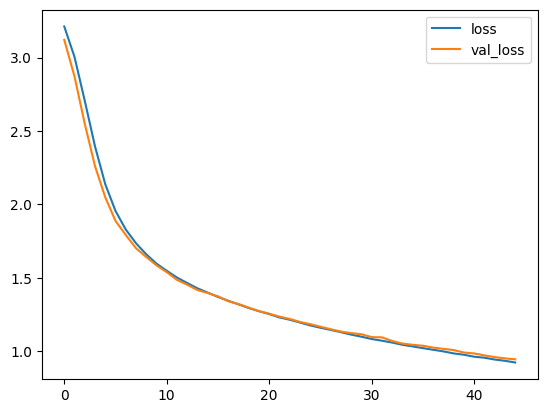

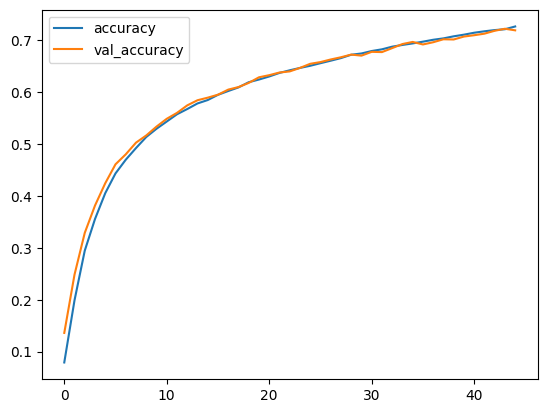

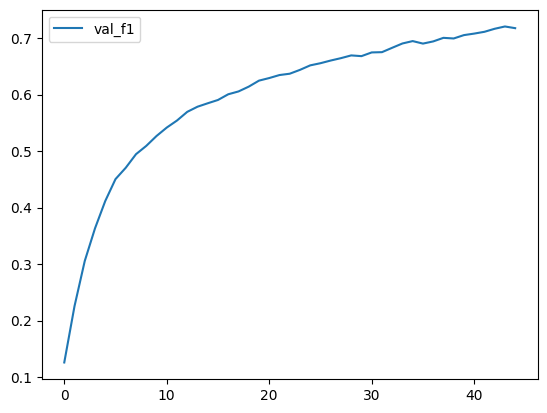

test loss: 0.9339212474656233, test accuracy: 0.7228365384615385, f1: 0.7214270039691406
best test loss: 0.9312148277905731, test accuracy: 0.7250961538461539, test f1: 0.7236751754170025


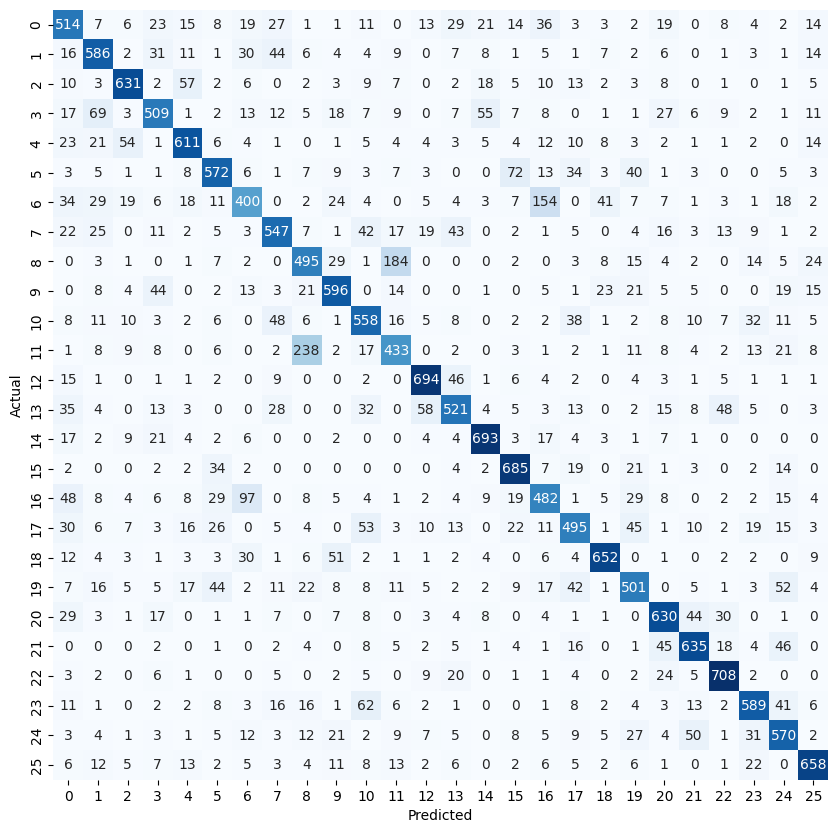

learning rate: 0.00075


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 1/45, loss: 3.2017, accuracy: 0.0820, val_loss: 3.1261, val_accuracy: 0.1282, val_f1: 0.1155


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 2/45, loss: 3.0386, accuracy: 0.1783, val_loss: 2.9446, val_accuracy: 0.2259, val_f1: 0.2057


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 3/45, loss: 2.8280, accuracy: 0.2605, val_loss: 2.7163, val_accuracy: 0.2915, val_f1: 0.2643


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 4/45, loss: 2.5831, accuracy: 0.3194, val_loss: 2.4693, val_accuracy: 0.3394, val_f1: 0.3125


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 5/45, loss: 2.3557, accuracy: 0.3603, val_loss: 2.2639, val_accuracy: 0.3789, val_f1: 0.3588


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 6/45, loss: 2.1653, accuracy: 0.3994, val_loss: 2.0966, val_accuracy: 0.4144, val_f1: 0.3984


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 7/45, loss: 2.0214, accuracy: 0.4262, val_loss: 1.9713, val_accuracy: 0.4377, val_f1: 0.4234


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 8/45, loss: 1.9115, accuracy: 0.4520, val_loss: 1.8706, val_accuracy: 0.4661, val_f1: 0.4540


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 9/45, loss: 1.8237, accuracy: 0.4722, val_loss: 1.7968, val_accuracy: 0.4794, val_f1: 0.4685


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 10/45, loss: 1.7501, accuracy: 0.4909, val_loss: 1.7307, val_accuracy: 0.4925, val_f1: 0.4827


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 11/45, loss: 1.6941, accuracy: 0.5063, val_loss: 1.6824, val_accuracy: 0.5098, val_f1: 0.5017


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 12/45, loss: 1.6451, accuracy: 0.5183, val_loss: 1.6344, val_accuracy: 0.5249, val_f1: 0.5169


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 13/45, loss: 1.5968, accuracy: 0.5314, val_loss: 1.5924, val_accuracy: 0.5340, val_f1: 0.5269


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 14/45, loss: 1.5592, accuracy: 0.5427, val_loss: 1.5536, val_accuracy: 0.5415, val_f1: 0.5340


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 15/45, loss: 1.5242, accuracy: 0.5530, val_loss: 1.5225, val_accuracy: 0.5511, val_f1: 0.5441


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 16/45, loss: 1.4935, accuracy: 0.5601, val_loss: 1.4960, val_accuracy: 0.5593, val_f1: 0.5527


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 17/45, loss: 1.4641, accuracy: 0.5677, val_loss: 1.4612, val_accuracy: 0.5768, val_f1: 0.5712


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 18/45, loss: 1.4386, accuracy: 0.5760, val_loss: 1.4409, val_accuracy: 0.5778, val_f1: 0.5724


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 19/45, loss: 1.4145, accuracy: 0.5817, val_loss: 1.4194, val_accuracy: 0.5875, val_f1: 0.5825


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 20/45, loss: 1.3930, accuracy: 0.5876, val_loss: 1.3878, val_accuracy: 0.5901, val_f1: 0.5854


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 21/45, loss: 1.3682, accuracy: 0.5977, val_loss: 1.3703, val_accuracy: 0.5970, val_f1: 0.5921


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 22/45, loss: 1.3514, accuracy: 0.6006, val_loss: 1.3486, val_accuracy: 0.5997, val_f1: 0.5951


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 23/45, loss: 1.3281, accuracy: 0.6068, val_loss: 1.3322, val_accuracy: 0.6105, val_f1: 0.6065


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 24/45, loss: 1.3107, accuracy: 0.6117, val_loss: 1.3112, val_accuracy: 0.6110, val_f1: 0.6067


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 25/45, loss: 1.2928, accuracy: 0.6183, val_loss: 1.3027, val_accuracy: 0.6134, val_f1: 0.6091


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 26/45, loss: 1.2766, accuracy: 0.6217, val_loss: 1.2833, val_accuracy: 0.6191, val_f1: 0.6157


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 27/45, loss: 1.2607, accuracy: 0.6272, val_loss: 1.2691, val_accuracy: 0.6239, val_f1: 0.6204


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 28/45, loss: 1.2445, accuracy: 0.6326, val_loss: 1.2521, val_accuracy: 0.6299, val_f1: 0.6265


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 29/45, loss: 1.2282, accuracy: 0.6351, val_loss: 1.2326, val_accuracy: 0.6381, val_f1: 0.6344


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 30/45, loss: 1.2151, accuracy: 0.6405, val_loss: 1.2267, val_accuracy: 0.6362, val_f1: 0.6332


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 31/45, loss: 1.1989, accuracy: 0.6457, val_loss: 1.2186, val_accuracy: 0.6400, val_f1: 0.6371


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 32/45, loss: 1.1878, accuracy: 0.6478, val_loss: 1.1982, val_accuracy: 0.6428, val_f1: 0.6397


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 33/45, loss: 1.1757, accuracy: 0.6512, val_loss: 1.1836, val_accuracy: 0.6499, val_f1: 0.6473


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 34/45, loss: 1.1610, accuracy: 0.6542, val_loss: 1.1726, val_accuracy: 0.6521, val_f1: 0.6495


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 35/45, loss: 1.1499, accuracy: 0.6587, val_loss: 1.1632, val_accuracy: 0.6570, val_f1: 0.6542


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 36/45, loss: 1.1389, accuracy: 0.6620, val_loss: 1.1460, val_accuracy: 0.6634, val_f1: 0.6611


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 37/45, loss: 1.1249, accuracy: 0.6645, val_loss: 1.1331, val_accuracy: 0.6657, val_f1: 0.6630


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 38/45, loss: 1.1118, accuracy: 0.6717, val_loss: 1.1298, val_accuracy: 0.6657, val_f1: 0.6631


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 39/45, loss: 1.1006, accuracy: 0.6737, val_loss: 1.1113, val_accuracy: 0.6713, val_f1: 0.6687


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 40/45, loss: 1.0922, accuracy: 0.6764, val_loss: 1.1070, val_accuracy: 0.6734, val_f1: 0.6710


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 41/45, loss: 1.0821, accuracy: 0.6789, val_loss: 1.0939, val_accuracy: 0.6736, val_f1: 0.6714


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 42/45, loss: 1.0711, accuracy: 0.6828, val_loss: 1.0810, val_accuracy: 0.6806, val_f1: 0.6779


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 43/45, loss: 1.0592, accuracy: 0.6847, val_loss: 1.0776, val_accuracy: 0.6809, val_f1: 0.6790


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 44/45, loss: 1.0493, accuracy: 0.6888, val_loss: 1.0683, val_accuracy: 0.6843, val_f1: 0.6822


Training: 100%|██████████ [ time left: 00:00 ]


epoch: 45/45, loss: 1.0383, accuracy: 0.6920, val_loss: 1.0593, val_accuracy: 0.6888, val_f1: 0.6869


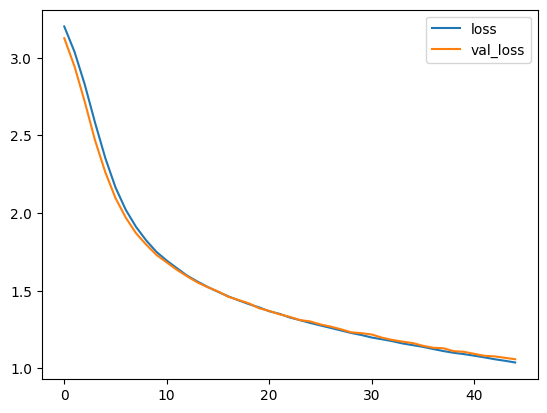

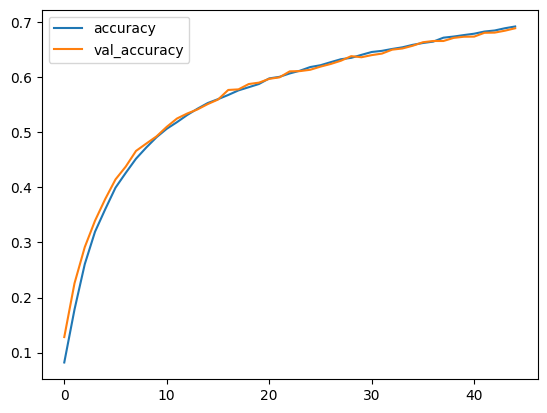

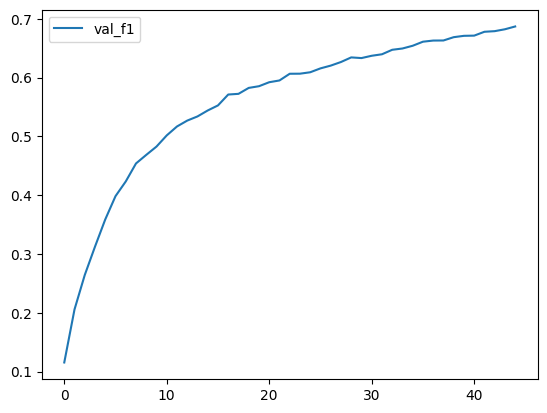

test loss: 1.0437187491834223, test accuracy: 0.6877884615384615, f1: 0.6859066499560496
best test loss: 1.0444338316966706, test accuracy: 0.691923076923077, test f1: 0.6900404101586067


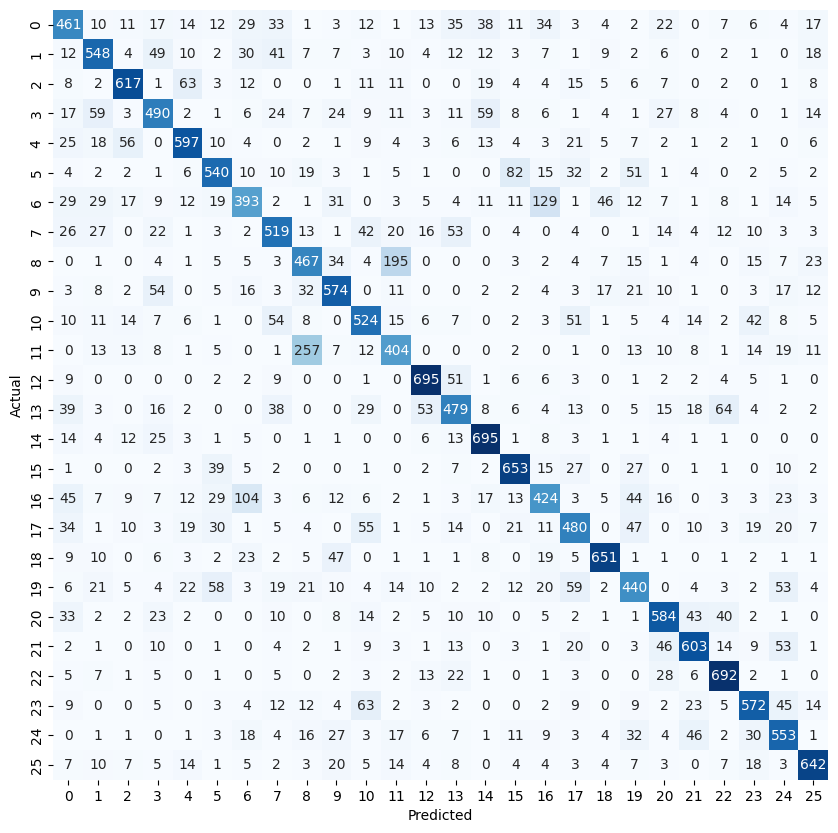

In [32]:
lr = [0.005, 0.0025, 0.001, 0.00075]
for lrate in lr:
    print(f"learning rate: {lrate}")
    print("===============")

    model = FNN(
        loss=CategoricalCrossEntropyLoss(),
        optimizer=SGD(learning_rate=lrate),
        learning_rate=lrate,
        layers=[
            Flatten(),
            DenseLayer(input_size, 512, ReLU()),
            DropoutLayer(dropout_rate=0.3),
            DenseLayer(512, 128, ReLU()),
            DropoutLayer(dropout_rate=0.3),
            DenseLayer(128, output_size, Softmax()),
        ]
    )

    # take only part after decimal point
    lrate_str = str(lrate).split(".")[1]

    # train
    model.fit(
        X=train_ds,
        y=train_labels,
        X_val=val_ds,
        y_val=val_labels,
        epochs=45,
        batch_size=64,
        best_name=f"best2_{lrate_str}.pkl"
    )

    # plot
    model.plot()

    # test model
    X_test = test_ds.data
    y_test = test_ds.targets
    test_loss, test_accuracy, f1 = model.evaluate(X_test, y_test)

    print(f"test loss: {test_loss}, test accuracy: {test_accuracy}, f1: {f1}")


    # test of best model
    test_loss, test_accuracy, f1 = model.best_model_evaluate(X_test, y_test)

    print(f"best test loss: {test_loss}, test accuracy: {test_accuracy}, test f1: {f1}")

    # plot confusion matrix
    model.plot_confusion_matrix(X_test, y_test)

    # save model
    model.save(f"last2_{lrate_str}.pkl")